In [2]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
        
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

In [52]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_*-n_query_0']
result_dir = './results/MVTecAD/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

auroc_list = {}
df = pd.DataFrame()
for log_dir in log_dirs:
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    


In [59]:
plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()
plot_df['sampling_method'] = plot_df['sampling_method'].apply(lambda x : f'Softpatch-{x}' if x != 'identity' else 'Patchcore')

<ipython-input-59-d06c828a46d2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = df.groupby(['sampling_method','anomaly_ratio'])['image_auroc','pixel_auroc'].mean().reset_index()


In [60]:
plot_df

,sampling_method,anomaly_ratio,image_auroc,pixel_auroc
0,Softpatch-gaussian,0.0,0.948283,0.974027
1,Softpatch-gaussian,0.1,0.948882,0.973244
2,Softpatch-gaussian,0.2,0.948355,0.970881
3,Patchcore,0.0,0.953535,0.974287
4,Patchcore,0.1,0.952671,0.969681
5,Patchcore,0.2,0.951469,0.967792
6,Softpatch-lof,0.0,0.952682,0.974153
7,Softpatch-lof,0.1,0.952658,0.974136
8,Softpatch-lof,0.2,0.952515,0.972509
9,Softpatch-nearest,0.0,0.949901,0.974031


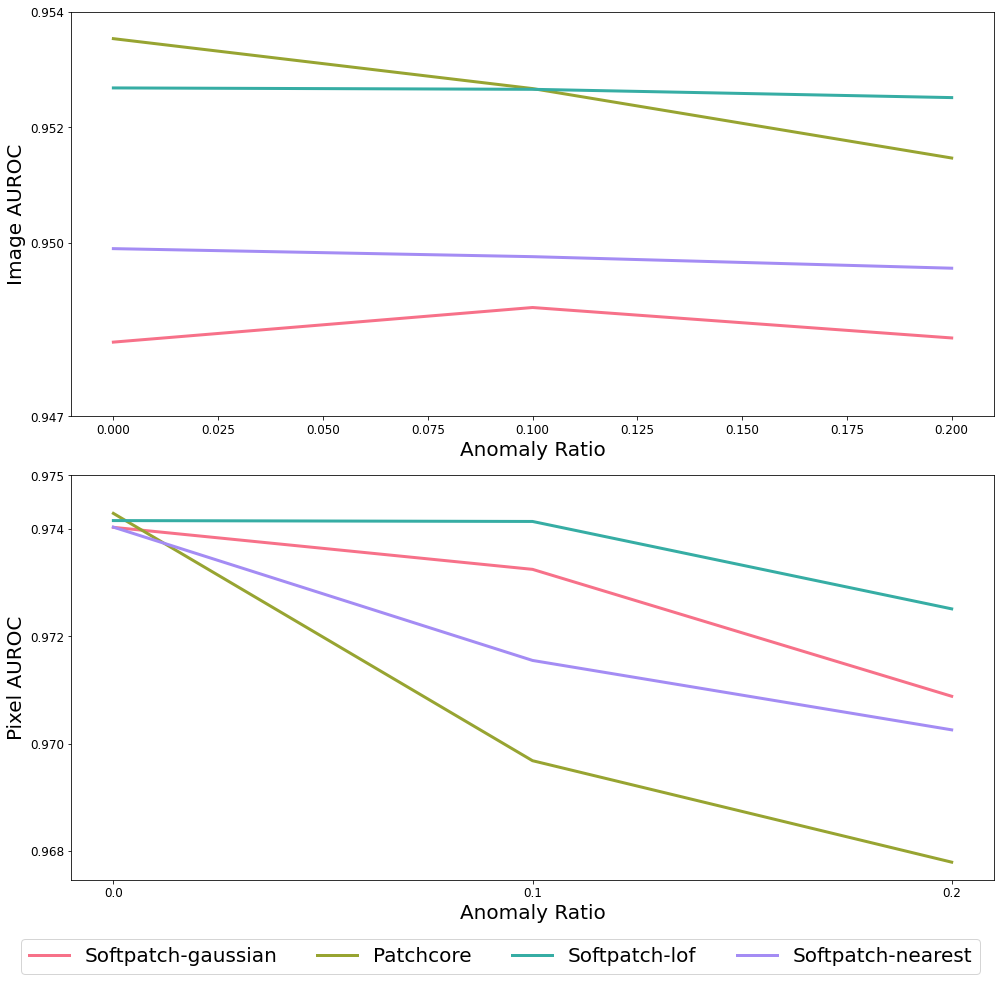

In [105]:
palette = sns.color_palette("husl", plot_df['sampling_method'].nunique())

fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Create the line plot on the first axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='image_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[0],
    palette=palette,  # Use the predefined palette
    linewidth=3
)

# Set the x-ticks for the first axes
axes[0].set_yticks([0.947,0.950,0.952,0.954])
axes[0].set_ylabel('Image AUROC', fontsize=20)
axes[0].set_xlabel('Anomaly Ratio', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].get_legend().remove()

# Create the line plot on the second axes with the defined palette
sns.lineplot(
    x='anomaly_ratio',
    y='pixel_auroc',
    hue='sampling_method',
    data=plot_df,
    ax=axes[1],
    palette=palette,  # Use the predefined palette,
    linewidth=3
)

# Remove the original legend generated by Seaborn for the second axes
axes[1].set_yticks([0.968,0.968+0.0020,0.972,0.974,0.975])
axes[1].set_xticks([0, 0.1, 0.2])
axes[1].set_ylabel('Pixel AUROC', fontsize=20)
axes[1].set_xlabel('Anomaly Ratio', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].get_legend().remove()

# Place the legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02), fontsize=20)

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.show()


In [90]:
0.975 - 0.00175

0.97325

In [87]:
(0.975 - 0.968)/4

0.0017500000000000016